# Semibatch Operation

## Introduction

Semibatch processes are widely employed in the polymer industry due to their inherent flexibility in controlling reaction conditions, enabling precise manipulation of polymer properties. In this notebook, we will illustrate the basic principles needed to model these systems by examining a classical solution homopolymerization, based on the reaction scheme outlined in [Notebook 5]. 

We assume a single-phase, well-stirred tank reactor where the mole balances for the species involved can be expressed as:

$$ \frac{\textrm{d}n_i}{\textrm{d}t} = F_{i,in} + r_i V $$

Here, $n_i$, $F_{i,in}$ and $r_i$ denote, respectively, the number of moles, the molar inflow, and the rate of production of species $i$, while $V$ represents the volume of the reaction mixture. The relevant species in our case include the initiator ($I$), monomer ($M$), optional solvent ($S$), radicals ($R^{\cdot}_n$), and dead polymer ($P_n$). Let us further suppose that we are only interested in the average chain length, rather than the full distribution of polymer chains. In this scenario, the **method of moments** can be used to reduce the complexity of the system. Specifically, we focus on the first three moments of the radical and polymer distributions:

\begin{align*}
\mu_k     & = \sum_{n=1}^{\infty} n^k [R_n^{\cdot}] \\
\lambda_k & = \sum_{n=1}^{\infty} n^k [P_n]
\end{align*}

with $k \in {0,1,2}$. As a result, the model will consist of molar balances for three species ($I$, $M$, $S$) and six pseudo-species ($\mu_0$, $\mu_1$, $\mu_2$,  $\lambda_0$, $\lambda_1$, and $\lambda_2$). The corresponding rates of formation are:  

\begin{align*}
r_{I} & = - k_d [I] \\
r_{M} & = - (k_p [M] \mu_0 + 2 f k_d [I]) \\
r_{S} & = 0 \\
r_{\mu_0} & = 2 f k_d [I] - 2 k_t \mu_0^2 \\
r_{\mu_1} & = 2 f k_d [I] + k_p [M] \mu_0 - 2 k_t \mu_0 \mu_1 \\
r_{\mu_2} & = 2 f k_d [I] + k_p [M] (\mu_0 + 2 \mu_1) - 2 k_t \mu_0 \mu_2 \\
r_{\lambda_0} & = (k_{tc} + 2 k_{td}) \mu_0^2 \\
r_{\lambda_1} & = 2 k_{t} \mu_0 \mu_1 \\
r_{\lambda_2} & = 2 k_{t} \mu_0 \mu_2 + 2 k_{tc} \mu_1^2
\end{align*}

The volume of the reaction mixture can be evaluated from the calculated mole amounts of monomer, solvent and polymer repeating units (initiator neglected):

$$ V \approx n_M \frac{MW_M}{\rho_M} + n_S \frac{MW_S}{\rho_S} + (n_{\mu_1} + n_{\lambda_1})\frac{MW_M}{\rho_P} $$

where $MW_i$ and $\rho_i$ represent, respectively, the molar mass and density of species $i$.

Given that chain-growth reactions are strongly exothermal, our model would not be complete without an energy balance:

$$ m_t c_p \frac{\textrm{d}T}{\textrm{d}t} = W_{in} c_p (T_{in} - T) + (-r_M)  V (-\Delta H_{pol}) + UA(T_j - T)$$

where $m_t$ is the total mass of the reaction mixture, $c_p$ is the average specific heat capacity of the reaction mixture and feed, $W_{in}$ is the total inlet mass flowrate, $T_{in}$ is the mean feed temperature, $\Delta H_{pol}$ is the polymerization enthalpy, $U$ is the overall heat transfer coefficient, $A$ is the heat transfer area, and $T_j$ is the jacket temperature. We assume the jacket temperature is automatically adjusted by means of a proportional-only controller (just to make the equations easier):

$$ T_j = T_{sp} - K_P(T - T_{sp}) $$

where $T_{sp}(t)$ is the reactor temperature setpoint. Additionally, we also estimate the maximum temperature of the synthesis reaction (MSTR), which is an important safety quantity:

$$ MTSR = T + \frac{n_M (-\Delta H_{pol})}{m_t c_p} $$

**Note**: One sometimes encouters semibatch models formulated with concentrations and volume as state variables. This can lead to unnecessary numerical issues (can you think of two examples?) and should be avoided. The state variables should preferably be extensive quantities like mass or moles, the latter having the advantage of working also for massless pseudo-species.

[Notebook 5]: 5_radical_polymerization.ipynb


## Numerical Solution

In [43]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

### Model Equations

This problem is more complex than the preceding ones, so it is essential to organize the code in a modular way. We will begin by implementing a helper function `arrhenius` to describe the temperature dependence of the rate coefficients.

In [44]:
def arrhenius(T: float, A: float, E: float, T0: float) -> float:
    """Arrhenius equation.

    Parameters
    ----------
    T : float
        Temperature (°C).
    A : float
        Pre-exponential factor (#/s).
    E : float
        Energy of activation (J/mol).
    T0 : float
        Reference temperature (°C).

    Returns
    -------
    float
        Value of rate coefficient at `T`.
    """
    R = 8.314  # J/(mol.K)
    return A * np.exp(-E / R * (1/(273.15 + T) - 1/(273.15 + T0)))

We can now implement a function to calculate the reaction rates for all species and moments.

In [45]:
def model_rates(C: np.ndarray, T: float, params: dict) -> np.ndarray:
    """Reaction rates.

    Parameters
    ----------
    C : np.ndarray
        Concentration vector (mol/L).
    T : float
        Temperature (°C).
    params : dict
        Model parameters.

    Returns
    -------
    np.ndarray
        Reaction rate vector (mol/(L.s)).
    """

    # Rate coefficients
    kinetics = params['kinetics']
    kd = arrhenius(T, **kinetics['kd'])
    kp = arrhenius(T, **kinetics['kp'])
    kt = arrhenius(T, **kinetics['kt'])
    f = kinetics['f']
    alpha = kinetics['alpha']

    ktd = kt*alpha
    ktc = kt*(1 - alpha)

    # Unpack concentrations
    I = C[0]
    M = C[1]
    mu = C[3:6]

    # Reaction rates
    r = np.empty_like(C)
    ri = 2*f*kd*I
    r[0] = -kd*I                                             # I
    r[1] = -(ri + kp*M*mu[0])                                # M
    r[2] = 0.                                                # S
    r[3] = ri - 2*kt*mu[0]**2                                # mu_0
    r[4] = ri + kp*M*mu[0] - 2*kt*mu[0]*mu[1]                # mu_1
    r[5] = ri + kp*M*(mu[0] + 2*mu[1]) - 2*kt*mu[0]*mu[2]    # mu_2
    r[6] = (ktc + 2*ktd)*mu[0]**2                            # lambda_0
    r[7] = 2*kt*mu[0]*mu[1]                                  # lambda_1
    r[8] = 2*kt*mu[0]*mu[2] + 2*ktc*mu[1]**2                 # lambda_1

    return r

Next, we implement a function to evaluate all _auxiliary_ variables that we wish to track over time but that are not state variables. This function will be called both _during_ and _after_ the integration.

In [72]:
def model_aux(t: float, n: np.ndarray, T: float, params: dict) -> tuple:
    """Auxiliary model function.

    Parameters
    ----------
    t : float
        Time (s).
    n : np.ndarray
        Components moles vector (mol).
    T : float
        Temparature (°C).
    params : dict
        Model parameters.

    Returns
    -------
    tuple
        Auxiliary variables.
    """

    # Unpack the moles vector (mol)
    n_I = n[0]
    n_M = n[1]
    n_S = n[2]
    n_mu1 = n[4]
    n_lambda1 = n[7]

    # Total mass of the reaction mixture (kg)
    MW = params['MW']
    mt = n_I*MW['I'] + (n_M + n_mu1 + n_lambda1)*MW['M'] + n_S*MW['S']

    # Total volume of the reaction mixture (L)
    rho = params['rho']
    V = n_M*(MW['M']/rho['M']) + n_S*(MW['S']/rho['S']) \
        + (n_mu1 + n_lambda1)*(MW['M']/rho['P'])

    # Molar concentrations (mol/L)
    C = n/(V + 1e-10)

    # Reaction rates (L/(mol.s))
    r = model_rates(C, T, params)

    # Component molar feed rates (mol/s)
    feed = params['feed']
    F = np.zeros_like(n)
    F[0] = feed['I'](t)
    F[1] = feed['M'](t)
    F[2] = feed['S'](t)

    # Total mass feed rate (kg/s)
    W = F[0]*MW['I'] + F[1]*MW['M'] + F[2]*MW['S']

    # Temperature control
    KP = params['control']['KP']
    T_sp = params['control']['T_sp'](t)
    Tj_min = params['control']['Tj_min']
    Tj_max = params['control']['Tj_max']
    Tj = T_sp - KP*(T - T_sp)
    Tj = np.clip(Tj, Tj_min, Tj_max)

    # MTSR
    DHpol = params['heatbal']['DHpol']
    cp = params['heatbal']['cp']
    MTSR = T + n_M*DHpol/(mt*cp + 1e-10)

    return mt, V, C, r, F, W, Tj, MTSR

All parts are now in place to implement the derivative of the state vector. This function is relatively straightforward, as most of the heavy lifting is handled by the previously defined functions.

In [73]:
def model_xdot(t: float, x: np.ndarray, params: dict) -> np.ndarray:
    """Calculate the derivative of the state vector, dx/dt.

    x = [n(I), n(M), n(S), n(mu_0)..n(mu_2), n(lambda_0)..n(lambda_2), T]

    Parameters
    ----------
    t : float
        Time (s).
    x : np.ndarray
        State vector.
    params : dict
        Model parameters.

    Returns
    -------
    np.ndarray
        Time derivative of the state vector.
    """
    # Unpack the state vector
    n = x[:-1]
    T = x[-1]

    # Allocate the state vector derivative
    xdot = np.zeros_like(x)
    ndot = xdot[:-1]
    Tdot = xdot[-1:]

    # Evaluate the auxiliary variables
    mt, V, _, r, F, W, Tj, _ = model_aux(t, n, T, params)

    # Material balances
    ndot[:] = F + r*V

    # Heat balance
    # This could also be moved to own function or model_aux
    heatbal = params['heatbal']
    cp = heatbal['cp']
    DHpol = heatbal['DHpol']
    Tin = heatbal['Tin']
    D = heatbal['D']
    U = heatbal['U']
    Qin = W*cp*(Tin - T)
    Qrxn = - DHpol*r[1]*V
    A = 4*((V*1e-3)/D)
    Qj = U*A*(T - Tj)

    Tdot[:] = (Qin + Qrxn - Qj)/(mt*cp + 1e-10)

    return xdot

Finally, we perform the numerical integration using a suitable ODE solver. This system is _very_ [stiff](https://en.wikipedia.org/wiki/Stiff_equation), therefore we need to choose an implicit solver like `LSODA`.

In [74]:
def solve_model(n0: np.ndarray,
                T0: float,
                tend: float,
                params: dict,
                ) -> tuple[np.ndarray, ...]:
    """Solve the dynamic model.

    Parameters
    ----------
    n0 : float
        Initial component moles (mol).
    T0 : float
        Initial reactor temperature (°C).
    params : dict
        Model parameters.
    tend : float
        Final time.

    Returns
    -------
    tuple[np.ndarray, ...]
        t, n, T, mt, V, C, F, W, Tj.
    """

    # Initial conditions
    x0 = np.hstack([n0, T0])

    solution = solve_ivp(model_xdot,
                         t_span=(0., tend),
                         y0=x0,
                         args=(params,),
                         method='LSODA',  # implicit solver is a MUST
                         rtol=1e-4,
                         atol=1e-10)

    # Unpack the solution
    t = solution.t
    x = solution.y
    n = x[0:-1, :]
    T = x[-1, :]

    # Compute aux variables
    mt = np.empty_like(t)
    V = np.empty_like(t)
    C = np.empty_like(n)
    F = np.empty_like(n)
    W = np.empty_like(t)
    Tj = np.empty_like(t)
    MTSR = np.empty_like(t)
    for i in range(t.size):
        mt[i], V[i], C[:, i], _, F[:, i], W[i], Tj[i], MTSR[i] = \
            model_aux(t[i], n[:, i], T[i], params)

    return t, n, T, mt, V, C, F, W, Tj, MTSR

### Input Parameters

We will use the parameters for XPTO, as reported by [X](X), as well as some educated guesses.

In [109]:
params = {
    'MW': {
        'I': 0.100,  # kg/mol
        'M': 0.100,  # kg/mol
        'S': 0.100,  # kg/mol
    },
    'rho': {
        'M': 1.0,  # kg/L
        'S': 0.8,  # kg/L
        'P': 1.2,  # kg/L
    },
    'feed': {
        'I': lambda t: 5e-2 if t<7*3600. else 0.,
        'M': lambda t: 5e0 if t<6*3600. else 0.,
        'S': lambda t: 3e0 if t<6*3600. else 0.,
    },
    'kinetics': {
        'f': 0.5,
        'alpha': 0.,
        'kd': {
            'A': 1e-3, # 1/s
            'E': 50e3,   # J/mol
            'T0': 100. # °C
        },
        'kp': {
            'A': 2e3,  # L/(mol.s)
            'E': 15e3,   # J/mol
            'T0': 100. # °C
        },
        'kt': {
            'A': 5e7,  # L/(mol.s)      
            'E': 20e2,   # J/mol
            'T0': 100. # °C
        },
    },
    'control': {
        'KP': 5.,
        'Tj_min': 35.,  # °C
        'Tj_max': 200., # °C
        'T_sp': lambda t: np.interp(t, [0., 1200., 5*3600.], [30., 100., 100.])  # °C
    },
    'heatbal':{
        'Tin': 25.,     # °C
        'D': 2.,        # m
        'U': 500.,      # W/(m2.K)
        'cp': 2100.,    # J/(kg.K)
        'DHpol': 80e3   # J/mol 
    }
}

# Initial reactor content
n0 = np.zeros(9)
n0[0] = 0.    # I
n0[1] = 0.    # M 
n0[2] = 2000. # S

# Initial temperature
T0 = params['control']['T_sp'](0.)

# Simulation time
tend = 10*3600

### ODE Solution

Finally, we perform the integration, which should be quite fast since there are only 10 states.

In [110]:
t, n, T, mt, V, C, F, W, Tj, MTSR = solve_model(n0, T0, tend, params)

### Plots

#### Reactor Contents

Text(0.5, 58.7222222222222, 'Time (h)')

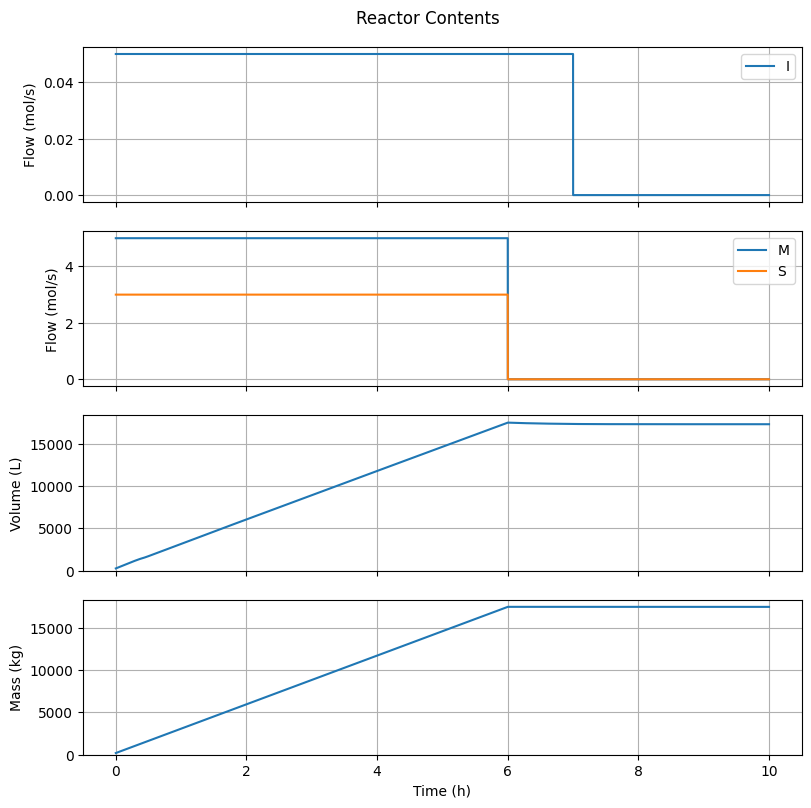

In [111]:
fig1, ax = plt.subplots(4, 1, sharex=True, figsize=(8, 8))
fig1.suptitle("Reactor Contents".title())
fig1.tight_layout()

# 0: I
# 1: M
# 2: S
# 3: mu_0
# 4: mu_1
# 5: mu_2
# 6: lambda_0
# 7: lambda_1
# 8: lambda_2

t_hour = t/3600

# Feed I
ax[0].plot(t_hour, F[0, :], label="I")
ax[0].set_ylabel("Flow (mol/s)")
ax[0].grid(True)
ax[0].legend(loc='upper right')

# Feed others
ax[1].plot(t_hour, F[1, :], label="M")
ax[1].plot(t_hour, F[2, :], label="S")
ax[1].set_ylabel("Flow (mol/s)")
ax[1].grid(True)
ax[1].legend(loc='upper right')

# Volume
ax[2].plot(t_hour, V)
ax[2].set_ylabel("Volume (L)")
ax[2].set_ylim(0., None)
ax[2].grid(True)

# Mass
ax[3].plot(t_hour, mt)
ax[3].set_ylabel("Mass (kg)")
ax[3].set_ylim(0., None)
ax[3].grid(True)

ax[-1].set_xlabel("Time (h)")

#### Species Amounts and Concentrations

Text(0.5, 58.7222222222222, 'Time (h)')

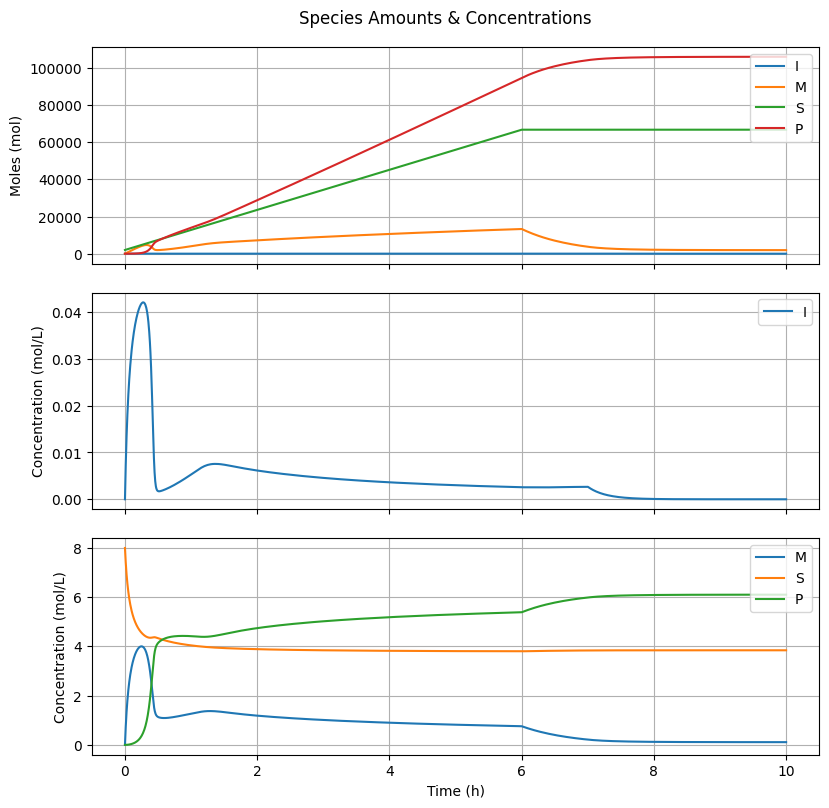

In [112]:
fig2, ax = plt.subplots(3, 1, sharex=True, figsize=(8, 8))
fig2.suptitle("Species amounts & concentrations".title())
fig2.tight_layout()

# 0: I
# 1: M
# 2: S
# 3: mu_0
# 4: mu_1
# 5: mu_2
# 6: lambda_0
# 7: lambda_1
# 8: lambda_2

# Number of moles
ax[0].plot(t_hour, n[0, :], label="I")
ax[0].plot(t_hour, n[1, :], label="M")
ax[0].plot(t_hour, n[2, :], label="S")
ax[0].plot(t_hour, n[4, :] + n[7, :], label="P")
ax[0].set_ylabel("Moles (mol)")
ax[0].grid(True)
ax[0].legend(loc='upper right')

# Molar concentration I
ax[1].plot(t_hour, C[0, :], label="I")
ax[1].set_ylabel("Concentration (mol/L)")
ax[1].grid(True)
ax[1].legend(loc='upper right')

# Molar concentrations others
ax[2].plot(t_hour, C[1, :], label="M")
ax[2].plot(t_hour, C[2, :], label="S")
ax[2].plot(t_hour, C[4, :] + C[7, :], label="P")
ax[2].set_ylabel("Concentration (mol/L)")
ax[2].grid(True)
ax[2].legend(loc='upper right')

ax[-1].set_xlabel("Time (h)")

#### Average Chain Length

Text(0.5, 36.72222222222221, 'Time (h)')

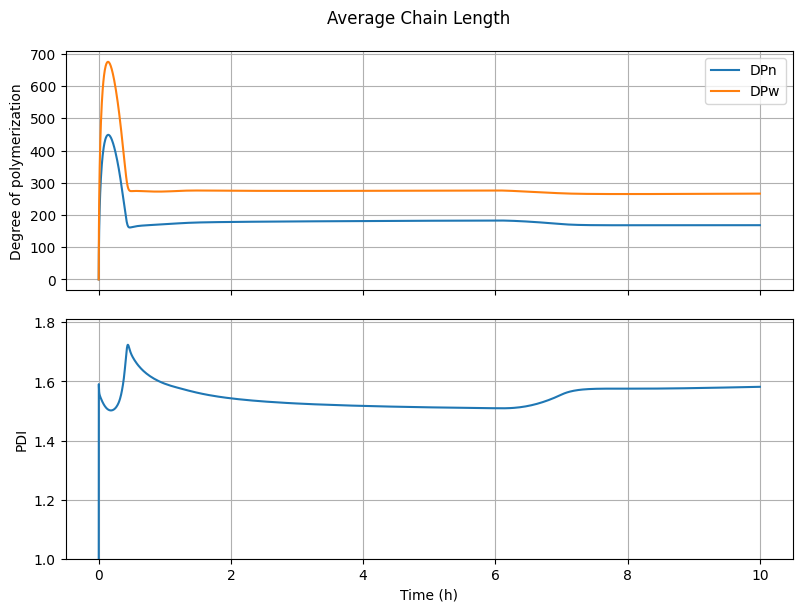

In [113]:
fig3, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
fig3.suptitle("Average chain length".title())
fig3.tight_layout()

# 0: I
# 1: M
# 2: S
# 3: mu_0
# 4: mu_1
# 5: mu_2
# 6: lambda_0
# 7: lambda_1
# 8: lambda_2

# DPn and DPn
DPn = (n[4, :] + n[7, :])/(n[3, :] + n[6, :] + 1e-10)
DPw = (n[5, :] + n[8, :])/(n[4, :] + n[7, :] + 1e-10)
ax[0].plot(t_hour, DPn, label="DPn")
ax[0].plot(t_hour, DPw, label="DPw")
ax[0].set_ylabel("Degree of polymerization")
ax[0].grid(True)
ax[0].legend(loc='best')

# PDI
PDI = DPw/(DPn + 1e-10)
ax[1].plot(t_hour, PDI)
ax[1].set_ylabel("PDI")
ax[1].set_ylim(1., None)
ax[1].grid(True)

ax[-1].set_xlabel("Time (h)")

### Temperature & Safety

Text(0.5, 23.52222222222222, 'Time (h)')

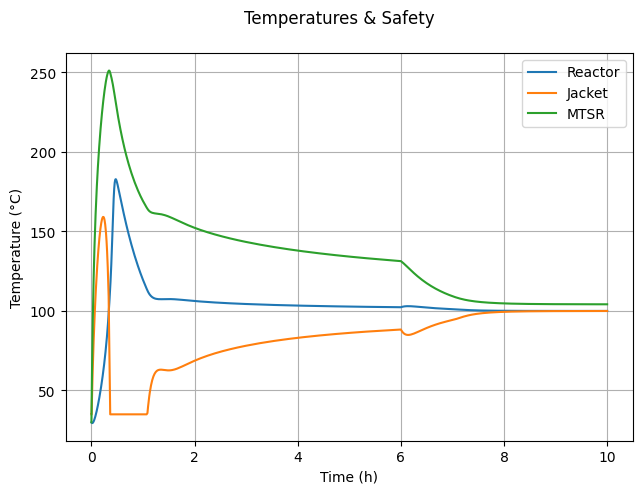

In [114]:
fig4, ax = plt.subplots(1, 1)
fig4.suptitle("Temperatures & safety".title())
fig4.tight_layout()

# Temperatures
ax.plot(t_hour, T, label="Reactor")
ax.plot(t_hour, Tj, label="Jacket")
ax.plot(t_hour, MTSR, label="MTSR")
ax.set_ylabel("Temperature (°C)")
ax.grid(True)
ax.legend()
ax.set_xlabel("Time (h)")

## Questions/Extras

* tbd